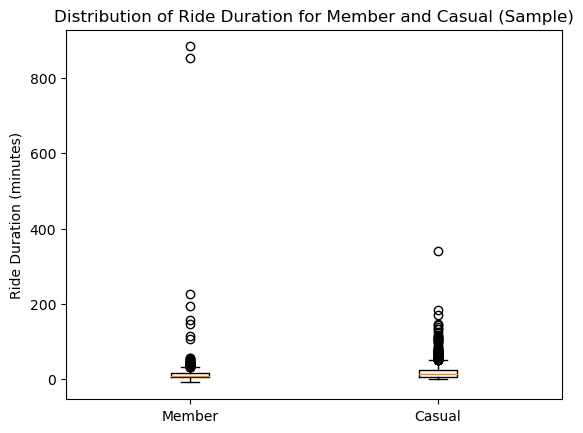

Difference in ride duration between member and casual:
U-statistic: 382157.5
p-value: 7.125644331334041e-20
Difference in proportions of bike types between member and casual:
Chi-square statistic: 64239.742759911176
p-value: 0.0


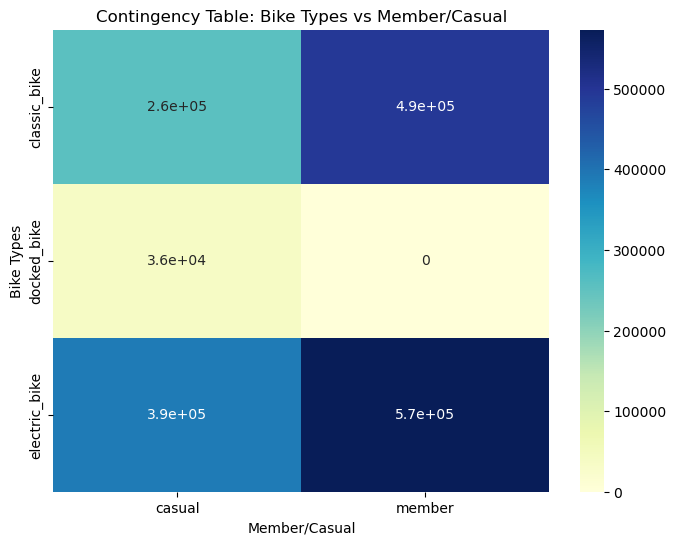

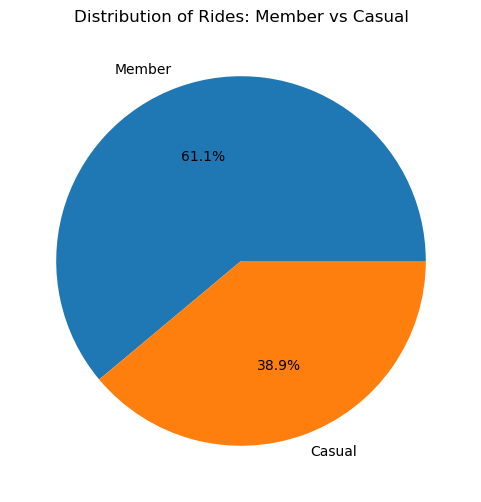

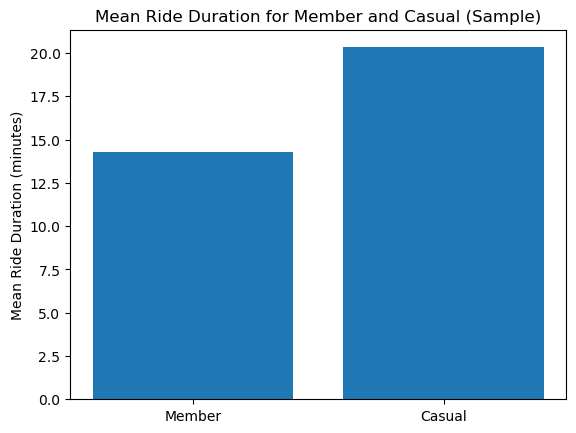

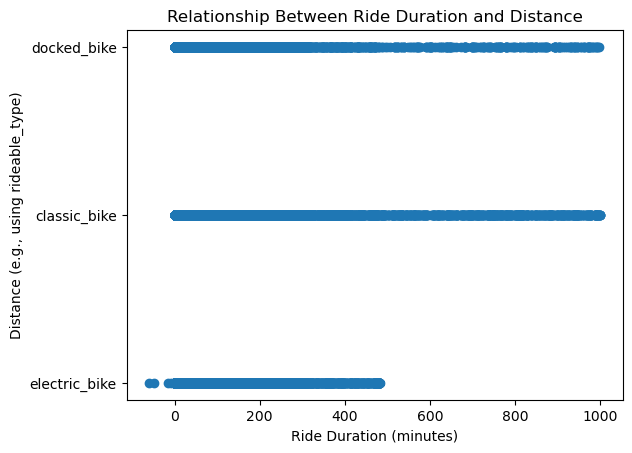

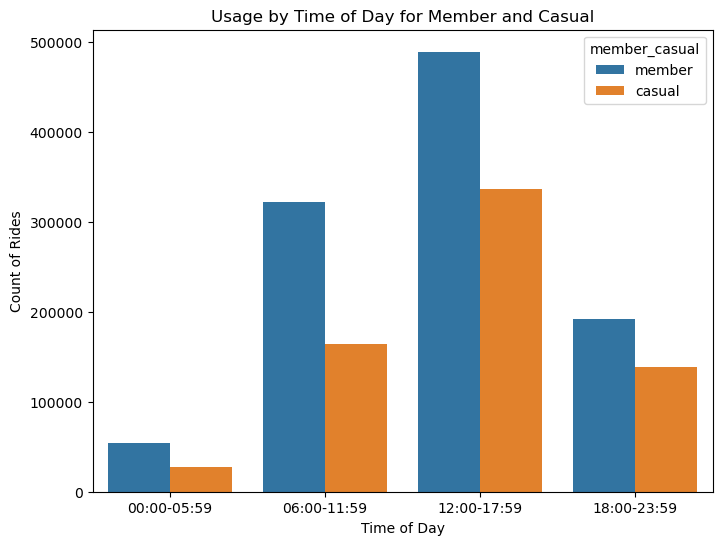

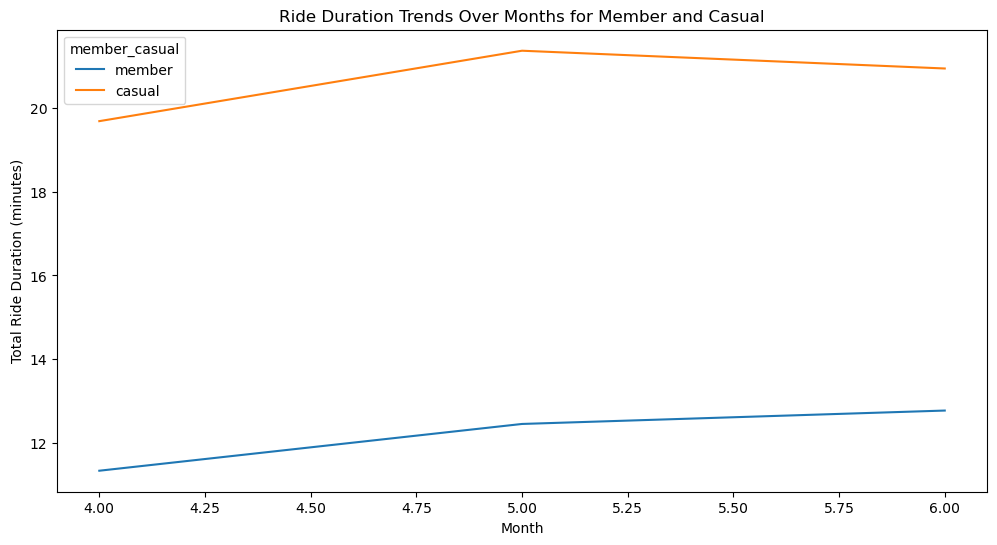

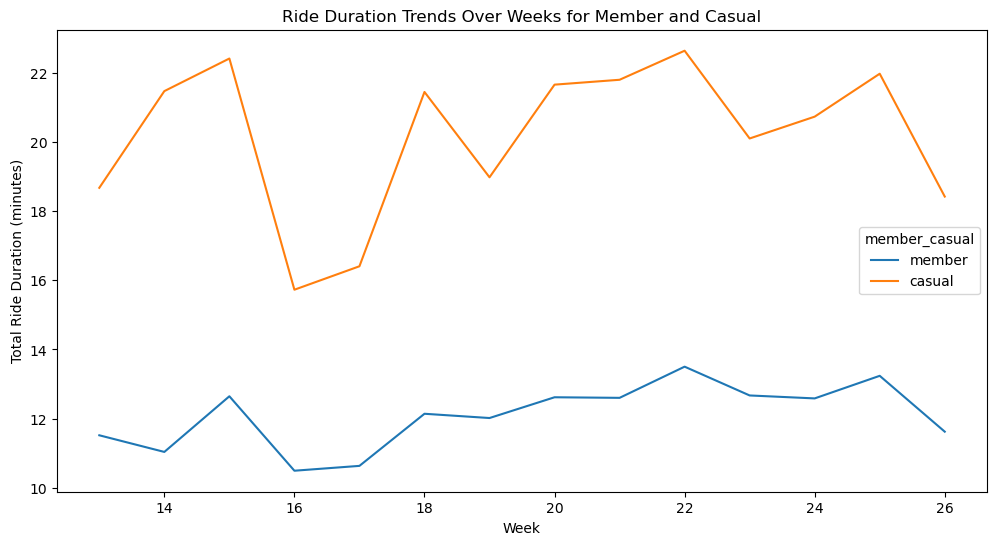

Map of End Locations for Member (Red), and Map of End Locations for Casual (Blue):


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, chi2_contingency
import folium
import warnings
from IPython.display import display

warnings.filterwarnings("ignore")

# Read CSV files
data1 = pd.read_csv('202304-divvy-tripdata.csv')
data2 = pd.read_csv('202305-divvy-tripdata.csv')
data3 = pd.read_csv('202306-divvy-tripdata.csv')

# Concatenate data from three files into one DataFrame
data = pd.concat([data1, data2, data3])

# Drop NaN values only in 'end_lat' and 'end_lng' columns
data_cleaned = data.dropna(subset=['end_lat', 'end_lng']).copy()  # Using copy() to avoid SettingWithCopyWarning

# Convert 'started_at' and 'ended_at' to datetime format
data_cleaned['started_at'] = pd.to_datetime(data_cleaned['started_at'])
data_cleaned['ended_at'] = pd.to_datetime(data_cleaned['ended_at'])

# Calculate ride duration in minutes
data_cleaned['ride_duration'] = (data_cleaned['ended_at'] - data_cleaned['started_at']).dt.total_seconds() / 60

# Drop data with 'ride_duration' greater than 1000 minutes
data_cleaned = data_cleaned[data_cleaned['ride_duration'] <= 1000]

# Separate data for member and casual
data_member = data_cleaned[data_cleaned['member_casual'] == 'member']
data_casual = data_cleaned[data_cleaned['member_casual'] == 'casual']

# Take a sample of data for member and casual
data_member_sample = data_member.sample(1000)
data_casual_sample = data_casual.sample(1000)

# Create boxplot for ride duration of member and casual sample
plt.boxplot([data_member_sample['ride_duration'], data_casual_sample['ride_duration']], labels=['Member', 'Casual'])
plt.ylabel('Ride Duration (minutes)')
plt.title('Distribution of Ride Duration for Member and Casual (Sample)')
plt.show()

# Calculate the difference in ride duration between member and casual
difference_duration = mannwhitneyu(data_member_sample['ride_duration'], data_casual_sample['ride_duration'], alternative='two-sided')

print("Difference in ride duration between member and casual:")
print("U-statistic:", difference_duration.statistic)
print("p-value:", difference_duration.pvalue)

# Create a contingency table of bike types for member and casual
contingency_table = pd.crosstab(data_cleaned['rideable_type'], data_cleaned['member_casual'])

# Calculate the difference in proportions of bike types between member and casual
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Difference in proportions of bike types between member and casual:")
print("Chi-square statistic:", chi2)
print("p-value:", p)

# Visualize the contingency table using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap='YlGnBu')
plt.title('Contingency Table: Bike Types vs Member/Casual')
plt.xlabel('Member/Casual')
plt.ylabel('Bike Types')
plt.show()

# Calculate the count of member and casual
member_count = len(data_member)
casual_count = len(data_casual)

# Create pie chart for member count
plt.figure(figsize=(6, 6))
plt.pie([member_count, casual_count], labels=['Member', 'Casual'], autopct='%1.1f%%')
plt.title('Distribution of Rides: Member vs Casual')
plt.show()

# Calculate the mean ride duration for member and casual
mean_duration_member = data_member_sample['ride_duration'].mean()
mean_duration_casual = data_casual_sample['ride_duration'].mean()

# Create a bar plot to compare the mean duration
plt.bar(['Member', 'Casual'], [mean_duration_member, mean_duration_casual])
plt.ylabel('Mean Ride Duration (minutes)')
plt.title('Mean Ride Duration for Member and Casual (Sample)')
plt.show()

# Create a scatter plot to analyze the relationship between duration and distance
plt.scatter(data_cleaned['ride_duration'], data_cleaned['rideable_type'])
plt.xlabel('Ride Duration (minutes)')
plt.ylabel('Distance (e.g., using rideable_type)')
plt.title('Relationship Between Ride Duration and Distance')
plt.show()

# Create time bins (e.g., morning, afternoon, evening)
time_bins = ['00:00-05:59', '06:00-11:59', '12:00-17:59', '18:00-23:59']
data_cleaned['time_of_day'] = pd.cut(data_cleaned['started_at'].dt.hour, bins=[0, 6, 12, 18, 24], labels=time_bins)

# Create a bar plot to compare the usage by time of day
plt.figure(figsize=(8, 6))
sns.countplot(data=data_cleaned, x='time_of_day', hue='member_casual')
plt.xlabel('Time of Day')
plt.ylabel('Count of Rides')
plt.title('Usage by Time of Day for Member and Casual')
plt.show()

# Extract month and week information
data_cleaned['month'] = data_cleaned['started_at'].dt.month
data_cleaned['week'] = data_cleaned['started_at'].dt.isocalendar().week

# Create line plots to visualize usage trends over months and weeks
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_cleaned, x='month', y='ride_duration', hue='member_casual', ci=None)
plt.xlabel('Month')
plt.ylabel('Total Ride Duration (minutes)')
plt.title('Ride Duration Trends Over Months for Member and Casual')
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=data_cleaned, x='week', y='ride_duration', hue='member_casual', ci=None)
plt.xlabel('Week')
plt.ylabel('Total Ride Duration (minutes)')
plt.title('Ride Duration Trends Over Weeks for Member and Casual')
plt.show()

# Create a map with end locations for member and casual
map_combined = folium.Map(location=[data_member_sample['end_lat'].mean(), data_member_sample['end_lng'].mean()], zoom_start=12)

# Add member markers to the map
for index, row in data_member_sample.iterrows():
    folium.CircleMarker([row['end_lat'], row['end_lng']], radius=3, color='red').add_to(map_combined)

# Add casual markers to the map
for index, row in data_casual_sample.iterrows():
    folium.CircleMarker([row['end_lat'], row['end_lng']], radius=3, color='blue').add_to(map_combined)

# Display the combined map
print("Map of End Locations for Member (Red), and Map of End Locations for Casual (Blue):")
display(map_combined)